In [1]:
import os
import sys
import git
import pathlib

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

In [3]:
print(f"Project Root Directory: {PROJ_ROOT}")

Project Root Directory: /repos/drl_csense


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from stable_baselines3.common.results_plotter import load_results, ts2xy, rolling_window

In [6]:
env_id = "BreakoutNoFrameskip-v4"
sparsity = 0.1
exp_tag = f"sparse_{sparsity}"
exp_name = f"{env_id}--{exp_tag}"

In [7]:
logfolder_root = pathlib.Path(PROJ_ROOT_PATH / "logging")

# Directory to save all training statistics
log_dir = pathlib.Path(logfolder_root / exp_name)
# os.makedirs(log_dir, exist_ok=True)

# Directory to save gif animations
gif_dir = pathlib.Path(log_dir / "gifs" / exp_name)
# os.makedirs(gif_dir, exist_ok=True)

# Directory to save models
models_dir = pathlib.Path(PROJ_ROOT_PATH / "models" / exp_name)
# os.makedirs(models_dir, exist_ok=True)

In [8]:
print(f"Log Directory: {log_dir}")

Log Directory: /repos/drl_csense/logging/BreakoutNoFrameskip-v4--sparse_0.1


In [9]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")

In [10]:
EXPERIMENT_LIST = [0,1,2,3,4]
TRAIN_STEPS = 1E7

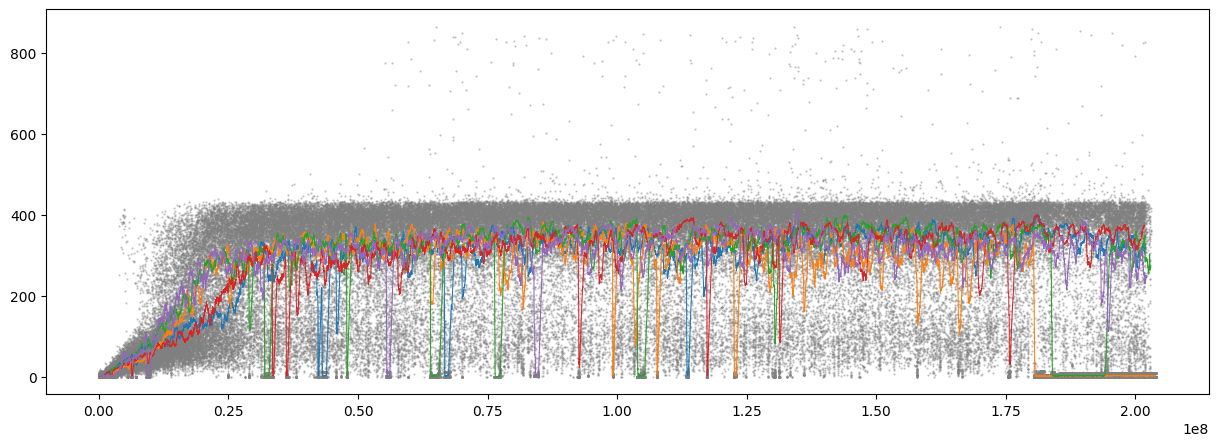

In [11]:
# Plotting
fig_width = 15
fig_height = 5
smoothing_window = 100

fig = plt.figure(figsize=[fig_width,fig_height])
for experiment in EXPERIMENT_LIST:
    run_log_dir = f"{log_dir}/run_{experiment}"
    x, y = ts2xy(load_results(run_log_dir), "timesteps")
    y_smooth = moving_average(y, window=smoothing_window)
    # Truncate x
    x_smooth = x[len(x) - len(y_smooth) : ]
    plt.scatter(x, y, s=0.4, c='gray', marker='o', alpha=0.4)  # Scatter plot of all data points
    plt.plot(x_smooth, y_smooth, linewidth=0.75)
    
    # plt.fill_between(x_all_smooth,
    #                  # yall_min, yall_max,
    #                  yall_mean-yall_std, yall_mean+yall_std, 
    #                  color='gray', 
    #                  alpha=0.3, 
    #                  label='std',
    #                 linewidth=0.05)  # Shaded standard deviation
plt.show()

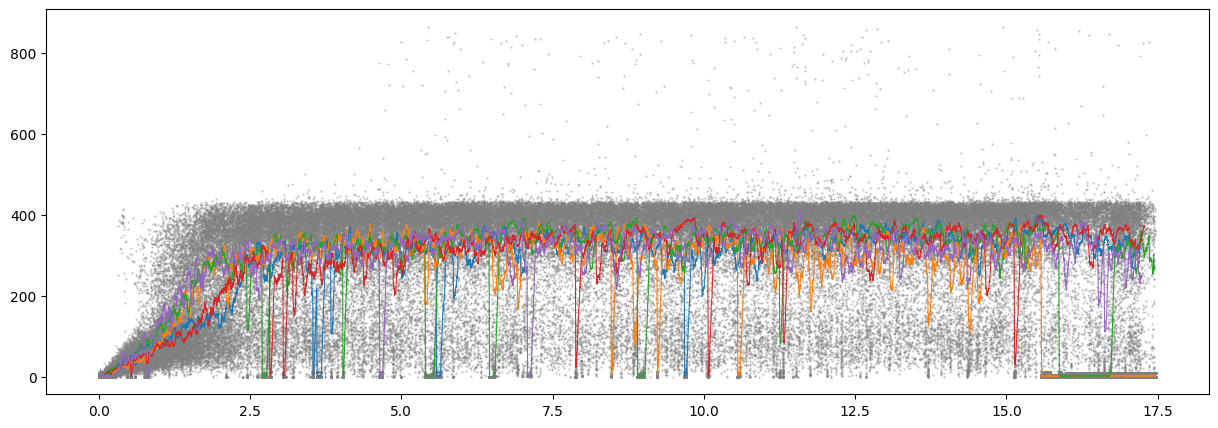

In [12]:
# Plotting
fig_width = 15
fig_height = 5
smoothing_window = 100

fig = plt.figure(figsize=[fig_width,fig_height])
for experiment in EXPERIMENT_LIST:
    run_log_dir = f"{log_dir}/run_{experiment}"
    x, y = ts2xy(load_results(run_log_dir), "walltime_hrs")
    y_smooth = moving_average(y, window=smoothing_window)
    # Truncate x
    x_smooth = x[len(x) - len(y_smooth) : ]
    plt.scatter(x, y, s=0.4, c='gray', marker='o', alpha=0.4)  # Scatter plot of all data points
    plt.plot(x_smooth, y_smooth, linewidth=0.75)
    
    # plt.fill_between(x_all_smooth,
    #                  # yall_min, yall_max,
    #                  yall_mean-yall_std, yall_mean+yall_std, 
    #                  color='gray', 
    #                  alpha=0.3, 
    #                  label='std',
    #                 linewidth=0.05)  # Shaded standard deviation
plt.show()

In [13]:
df = pd.DataFrame()

In [14]:
smoothing_window = 100
for experiment in EXPERIMENT_LIST:
    run_log_dir = f"{log_dir}/run_{experiment}"
    x, y = ts2xy(load_results(run_log_dir), "timesteps")
    
    # moving average
    y = moving_average(y, window=smoothing_window)
    # Truncate x
    x = x[len(x) - len(y) : ]
    
    new_df = pd.DataFrame({'x': x, f"run_{experiment}": y})
    df = pd.concat([df, new_df], ignore_index=True)

In [15]:
df = df.sort_values('x')
# df[:10]

In [16]:
# combine rows with same timesteps
agg_functions = {'run_0': 'mean', 'run_1': 'max', 'run_2': 'max', 'run_3': 'max' }
df = df.groupby(df['x']).aggregate(agg_functions)
# df[:10]

In [17]:
df = df.interpolate(method='linear', limit_direction='forward', axis=0)
df = df.fillna(0)
# df[:10]

In [18]:
df['avg'] = df[['run_0', 'run_1', 'run_2', 'run_3']].mean(axis=1)
df['std'] = df[['run_0', 'run_1', 'run_2', 'run_3']].std(axis=1)
df['min'] = df[['run_0', 'run_1', 'run_2', 'run_3']].min(axis=1)
df['max'] = df[['run_0', 'run_1', 'run_2', 'run_3']].max(axis=1)

In [22]:
# df

In [20]:
x = df.index.values
y_avg = df['avg'].to_numpy()
y_min = df['min'].to_numpy()
y_max = df['max'].to_numpy()
y_std = df['std'].to_numpy()

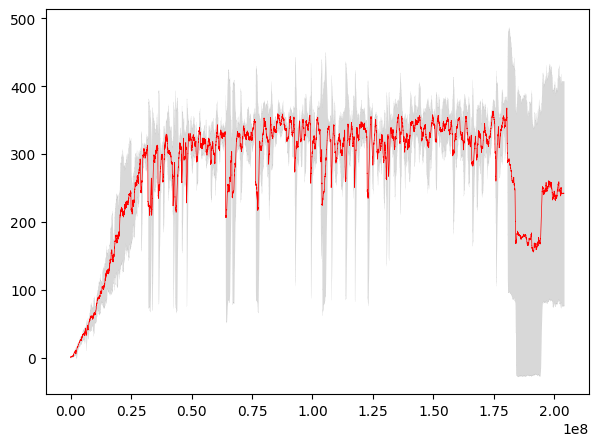

In [21]:
# Plotting
fig_width = 7
fig_height = 5
fig = plt.figure(figsize=[fig_width,fig_height])


plt.plot(x, y_avg, 
         'r-', 
         label=f"Avg, smoothing={smoothing_window} ",
        linewidth=0.5)  # Average line

plt.fill_between(x,
                 # y_min, y_max,
                 y_avg-y_std, y_avg+y_std, 
                 color='gray', 
                 alpha=0.3, 
                 label='std',
                linewidth=0.05)  # Shaded standard deviation
# plt.legend()
plt.show()